# DataJoint Elements for Electrode Localization

#### Open-source data pipeline for localizing Neuropixels electrodes within the Allen brain atlas - [Allen Mouse Common Coordinate Framework (CCF)](https://atlas.brain-map.org/)

Welcome to the tutorial for the DataJoint Element for electrode localization. This tutorial aims to provide a comprehensive understanding of the open-source data pipeline created using `element-electrode-localization`.

![flowchart](../images/flowchart.svg)

This package is designed to seamlessly ingest and track **electrode localization** data using DataJoint. 

![flowchart](../images/pipeline.svg)

By the end of this tutorial, you will have a clear grasp on setting up  `element-electrode-localization` into your specific research projects and lab.

### Prerequisites
Please see the [datajoint tutorials GitHub repository](https://github.com/datajoint/datajoint-tutorials/tree/main) before proceeding.

#### **Tutorial Overview**
+ Setup
+ *Activate* the DataJoint pipeline.
+ *Insert* example data into subject and session tables.
+ *Description* of the main tables.

### **Setup**
This tutorial describes the DataJoint tables that track the electrode localization data acquired with Neuropixels probes. The goal is to store, track, and manage all metadata associated with electrode localization and position probes, aligning to the Common Coordinate Framework (CCF) space within the Allen brain atlas.

The results of this Element can be combined with **other modalities** to create a complete, customizable data pipeline for your specific lab or study. For instance, you can combine `element-electrode-localization` with `element-array-ephys` and `element-event` to characterize the neural activity during specific stimulus events.

Let's start this tutorial by importing the packages necessary to run the notebook.

In [1]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
assert os.path.basename(os.getcwd()) == "element-electrode-localization", (
    "Please move to the " + "element directory"
)

In [2]:
import datajoint as dj
from pathlib import Path
import yaml

If the tutorial is run in Codespaces, a private, local database server is created and made available for you. This is where we will insert and store our processed results. Let's connect to the database server.

In [3]:
dj.conn()

[2024-01-18 21:54:08,426][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2024-01-18 21:54:08,436][INFO]: Connected root@fakeservices.datajoint.io:3306


DataJoint connection (connected) root@fakeservices.datajoint.io:3306

### **Activate the DataJoint Pipeline**

This tutorial presumes that the `element-electrode-localization` has been pre-configured and instantiated, with the database linked downstream to pre-existing `subject` and `session` tables. Please refer to the [`tutorial_pipeline.py`](./tutorial_pipeline.py) for the source code.

Now, we will proceed to import the essential schemas required to construct this data pipeline, with particular attention to the primary component: `electrode_localization`.

In [4]:
from tutorial_pipeline import (
    subject,
    session,
    electrode_localization,
    coordinate_framework,
    ephys
)

[2024-01-18 21:54:10,997][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.


We can represent the tables in the `electrode-localization` schema as well as some of the upstream dependencies to `session` and `subject` schemas as a diagram.


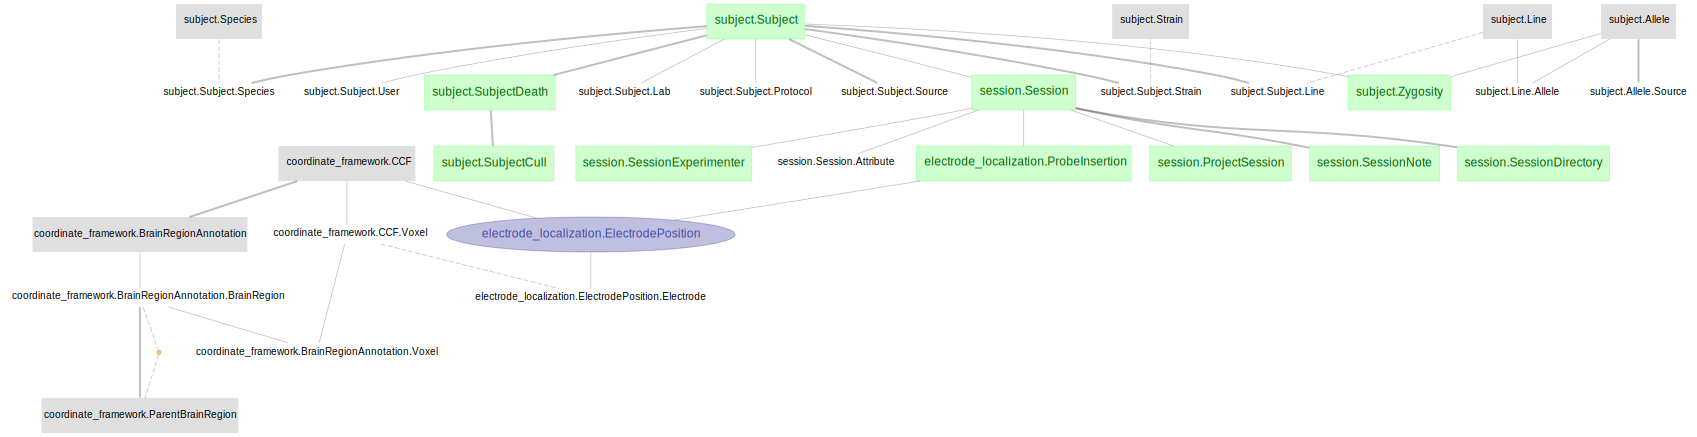

In [5]:
(
    dj.Diagram(subject)
    + dj.Diagram(session)
    + dj.Diagram(electrode_localization)
    + dj.Diagram(coordinate_framework)
    + dj.Diagram(ephys.ProbeInsertion)
)

As evident from the diagram, this data pipeline encompasses tables associated with electrode localization data. A few tables, such as `subject.Subject` and `session.Session`, while important for a complete pipeline, fall outside the scope of the `element-electrode-localization` tutorial, and will therefore, not be explored extensively here. The primary focus of this tutorial will be on the `electrode-localization` schema.

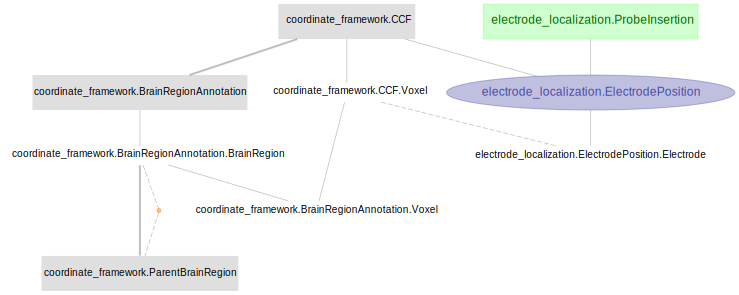

In [6]:
(
    dj.Diagram(electrode_localization)
    + dj.Diagram(ephys.ProbeInsertion)
    + dj.Diagram(coordinate_framework)
)

### **Insert example data into subject and session tables**

Now, let's delve into the `subject.Subject` and `session.Session` tables and include some example data.

In [7]:
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description


Add a new entry for a subject in the `Subject` table:

In [8]:
# Subject and Session tables
subject.Subject.insert1(
    dict(
        subject="subject6",
        sex="F",
        subject_birth_date="2020-01-01",
        subject_description="test0",
    ),
    skip_duplicates=True,
)

Create session keys and input them into the `Session` table:

In [9]:
# Definition of the dictionary named "session_keys"
session_keys = [
    dict(subject="subject6", session_datetime="2021-06-02 14:04:22"),
    dict(subject="subject6", session_datetime="2021-06-03 14:43:10"),
]

# Insert this dictionary in the Session table
session.Session.insert(session_keys, skip_duplicates=True)

Confirm the inserted data:

In [10]:
session.Session()

subject,session_datetime
subject6,2021-06-02 14:04:22
subject6,2021-06-03 14:43:10


### **Description of the main tables**

To know what data to insert into the table, we can view its dependencies and attributes using the `.heading` method. `heading` provides an exhaustive list of the table's attributes. This list includes both the attributes declared in this table and any inherited from upstream tables.

`ProbeInsertion` table will contain the data for probe insertion implanted into an animal for a given session. Let's insert some example data into the `ProbeInsertion` table as well:

In [11]:
electrode_localization.ProbeInsertion.heading

# Probe insertion implanted into an animal for a given session.
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
insertion_number     : tinyint unsigned             # 
---
probe                : varchar(32)                  # unique identifier for this model of probe (e.g. serial number)

`ElectrodePosition` table computes the electrode position information for a probe insertion.    

In [12]:
electrode_localization.ElectrodePosition.heading

# 
subject              : varchar(8)                   # 
session_datetime     : datetime                     # 
insertion_number     : tinyint unsigned             # 
ccf_id               : int                          # CCF ID, a.k.a atlas ID

### Summary

Following this tutorial, we have:

- Covered the essential description of `element-electrode-localization`
- Learned how to manually insert data into tables

#### Documentation and DataJoint tutorials

+ Detailed [documentation on `element-electrode-localization`](https://datajoint.com/docs/elements/element-electrode-localization/0.1/)
+  [General `DataJoint-Python` interactive tutorials](https://github.com/datajoint/datajoint-tutorials), covering fundamentals, such as table tiers, query operations, fetch operations, automated computations with the make function, and more.
+ [Documentation for `DataJoint-Python`](https://datajoint.com/docs/core/datajoint-python/0.14/)